In [115]:
import numpy as np
import random
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, auc, RocCurveDisplay, f1_score
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import xgboost as xgb
import matplotlib.pyplot as plt

def seed_it_all(seed=17):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_it_all()

# Study on Myopia Among Children

The goal of this project is to develop models which can predict how likely a child is to become myopic. The dataset we will use was obtained from a study that tracked children and their habits to see who later developed myopia.

In [187]:
# Read and view the dataset

data_set = pd.read_csv('myopia.csv', sep = ';')

data_set

,ID,STUDYYEAR,MYOPIC,AGE,GENDER,SPHEQ,AL,ACD,LT,VCD,SPORTHR,READHR,COMPHR,STUDYHR,TVHR,DIOPTERHR,MOMMY,DADMY
0,1,1992,1,6,1,-0.052,21.89,3.690,3.498,14.70,45,8,0,0,10,34,1,1
1,2,1995,0,6,1,0.608,22.38,3.702,3.392,15.29,4,0,1,1,7,12,1,1
2,3,1991,0,6,1,1.179,22.49,3.462,3.514,15.52,14,0,2,0,10,14,0,0
3,4,1990,1,6,1,0.525,22.20,3.862,3.612,14.73,18,11,0,0,4,37,0,1
4,5,1995,0,5,0,0.697,23.29,3.676,3.454,16.16,14,0,0,0,4,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,614,1995,1,6,0,0.678,22.40,3.663,3.803,14.93,2,0,7,3,14,37,1,0
614,615,1993,0,6,1,0.665,22.50,3.570,3.378,15.56,6,0,1,0,8,10,1,1
615,616,1995,0,6,0,1.834,22.94,3.624,3.424,15.89,8,0,0,0,4,4,1,1
616,617,1991,0,6,1,0.665,21.92,3.688,3.598,14.64,12,2,1,0,15,23,0,0


Let's see some basic statistics on the dataset

Are there missing values? False


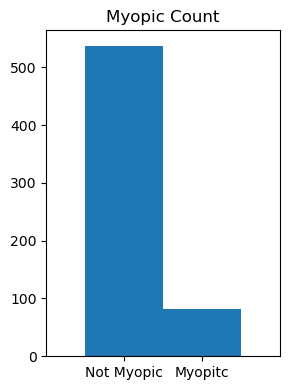

,ID,STUDYYEAR,MYOPIC,AGE,GENDER,SPHEQ,AL,ACD,LT,VCD,SPORTHR,READHR,COMPHR,STUDYHR,TVHR,DIOPTERHR,MOMMY,DADMY
count,618.000000,618.000000,618.000000,618.000000,618.000000,618.000000,618.000000,618.000000,618.000000,618.000000,618.000000,618.000000,618.000000,618.000000,618.000000,618.000000,618.000000,618.000000
mean,309.500000,1992.359223,0.131068,6.299353,0.488673,0.801010,22.496780,3.578629,3.541453,15.376780,11.953074,2.796117,2.105178,1.490291,8.948220,26.017799,0.506472,0.498382
std,178.545512,1.734507,0.337748,0.712950,0.500277,0.625918,0.680141,0.230394,0.154519,0.664183,7.968296,3.068191,3.056508,2.216207,5.719021,16.031715,0.500363,0.500402
min,1.000000,1990.000000,0.000000,5.000000,0.000000,-0.699000,19.900000,2.772000,2.960000,13.380000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
25%,155.250000,1991.000000,0.000000,6.000000,0.000000,0.456250,22.040000,3.424000,3.436000,14.930000,6.000000,0.000000,0.000000,0.000000,4.250000,15.000000,0.000000,0.000000
50%,309.500000,1992.000000,0.000000,6.000000,0.000000,0.729000,22.465000,3.585000,3.542000,15.360000,10.000000,2.000000,1.000000,1.000000,8.000000,23.000000,1.000000,0.000000
75%,463.750000,1994.000000,0.000000,6.000000,1.000000,1.034000,22.970000,3.730000,3.640000,15.840000,16.000000,4.000000,3.000000,2.000000,12.000000,34.000000,1.000000,1.000000
max,618.000000,1995.000000,1.000000,9.000000,1.000000,4.372000,24.560000,4.250000,4.112000,17.300000,45.000000,20.000000,30.000000,15.000000,31.000000,101.000000,1.000000,1.000000


In [186]:
print(f'Are there missing values? {len(data_set.columns) != len(data_set.dropna().columns)}')

plt.figure(figsize=(3, 4))
plt.title('Myopic Count')

counts, bins = np.histogram(data_set.MYOPIC, bins=2)
plt.hist(bins[:-1], bins, weights=counts, align='mid')

plt.xticks([0.25, 0.75], ['Not Myopic', 'Myopitc'])
plt.xlim([-0.25, 1.25])

plt.tight_layout()
plt.show()

data_set.describe()

Here is an outline for our course of action on this dataset.

Plan:

Models to implement:
1) Logistic regression
2) SVM

    (a) Do a box search to find the best regularization parameter and kernel to use
    
3) KNN

    (a) Use PCA to extract important features.
    (b) Do a box search for the best number of features and the value of K for the KNN algorithm
    
4) GBDT
5) DNN

    (a) Do a box search for the following hyperparameters: width, depth, learning rate

Performence metrics: The following metrics will be computed over a 10 fold CV
1) Plot the ROC curve and compute AUC

2) Compute the confusion matrix and F1 score for each

Since the dataset is clearly inbalanced as shown in the plot above, we will at the end engineer new examples using the SMOTE technique. Then we will retrain our models using the larger dataset. We will choose two best models with highest CV F1 score trained on the original dataset and the oversampled dataset. At the end we will compare how these best models perform on the test set. 

In [4]:
# Split into training and test sets. Later we will do CV on the training set to select our best model

X = data_set.loc[:,[col not in ['ID', 'STUDYYEAR', 'MYOPIC'] for col in data_set.columns]].values
y = data_set.MYOPIC.values

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [111]:
# Import necessary models

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


lr = LogisticRegression(C=100, solver='lbfgs')
forest = RandomForestClassifier(n_estimators=500)
bst = XGBClassifier(n_estimators=1000, objective='binary:logistic')

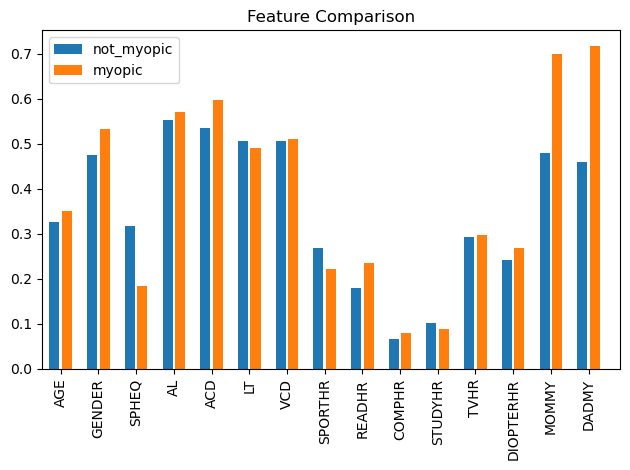

In [178]:
# Using only the training set, we will see how each feature behaves with respect to myopia

feat_labels = data_set.loc[:,[col not in ['ID', 'STUDYYEAR', 'MYOPIC'] for col in data_set.columns]].columns
mms = MinMaxScaler()

X_train_st = mms.fit_transform(X_train)

X_neg = X_train_st[y_train == 0,]
X_pos = X_train_st[y_train == 1,]

plt.title('Feature Comparison')
plt.bar(np.arange(1,X_train.shape[1]*3+1,3), np.mean(X_neg, axis=0), align='center', label='not_myopic')
plt.bar(np.arange(2,X_train.shape[1]*3+2,3), np.mean(X_pos, axis=0), align='center', label='myopic')

plt.xticks(np.arange(1.5,X_train.shape[1]*3+1,3), feat_labels, rotation=90)
plt.xlim([0, X_train.shape[1]*3+1])

plt.legend()
plt.tight_layout()
plt.show()

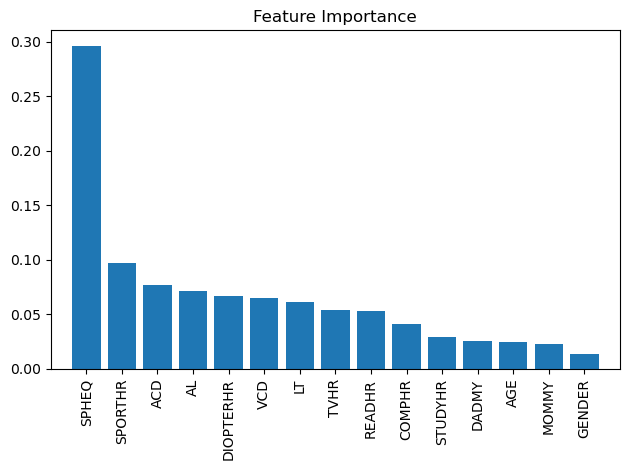

In [45]:
feat_labels = data_set.loc[:,[col not in ['ID', 'STUDYYEAR', 'MYOPIC'] for col in data_set.columns]].columns

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')

plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])

plt.tight_layout()
plt.show()

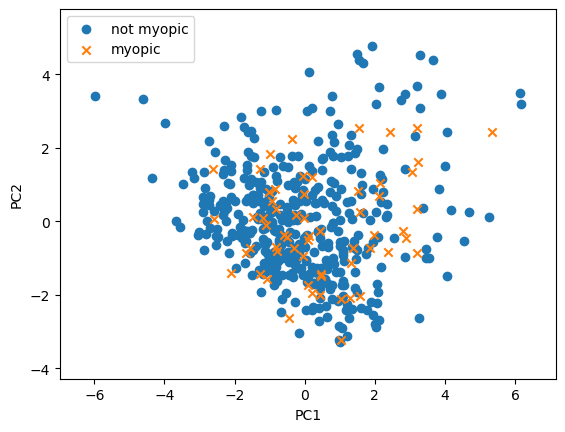

In [71]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
pca = PCA(n_components=2)

X_train_std = sc.fit_transform(X_train)
X_train_pca = pca.fit_transform(X_train_std)

x1_min, x1_max = X_train_pca[:,0].min()-1, X_train_pca[:,0].max()+1
x2_min, x2_max = X_train_pca[:,1].min()-1, X_train_pca[:,1].max()+1

plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)

plt.scatter(x=X_train_pca[y_train == 0, 0],
            y=X_train_pca[y_train == 0, 1],
            marker='o',
            label='not myopic')

plt.scatter(x=X_train_pca[y_train == 1, 0],
            y=X_train_pca[y_train == 1, 1],
            marker='x',
            label='myopic')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

In [77]:
pipe_knn = make_pipeline(StandardScaler(), PCA(), KNeighborsClassifier())

param_grid = [{'pca__n_components': [2, 3, 4, 5],
               'kneighborsclassifier__n_neighbors': [3, 5, 7, 9],
               'kneighborsclassifier__weights': ['uniform', 'distance']}]

gs = GridSearchCV(estimator=pipe_knn, param_grid=param_grid,
                  scoring='f1', cv=10,
                  refit=True, n_jobs=-1)

gs = gs.fit(X, y)
print(gs.best_score_)
params = gs.best_params_
print(gs.best_params_)

knn = KNeighborsClassifier(n_neighbors=params['kneighborsclassifier__n_neighbors'], weights=params['kneighborsclassifier__weights'])

0.26506715506715506
{'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__weights': 'uniform', 'pca__n_components': 5}


In [117]:
pipe_svc = make_pipeline(MinMaxScaler(), SVC())

param_range = [1e4, 1e3, 1e2, 1e1, 1, 1e-1, 1e-2, 1e-3, 1e-4]

param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid,
                  scoring='f1', cv=10,
                  refit=True, n_jobs=-1)

gs = gs.fit(X, y)
print(gs.best_score_)
params = gs.best_params_
print(gs.best_params_)


svc = SVC(C=params['svc__C'], kernel=params['svc__kernel'], gamma=params['svc__gamma'])

0.3910250533779946
{'svc__C': 10000.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


In [157]:
from tensorflow.keras import backend as K

def build_model(hp):
    model = keras.Sequential()
    
    hp_units = hp.Int('units', min_value=16, max_value=64, step=16)
    hp_depth = hp.Choice('depth', values=[2,3,4])
    
    for _ in range(hp_depth):
        model.add(layers.Dense(hp_units))
        model.add(layers.LeakyReLU())

    model.add(layers.Dense(1, activation='sigmoid'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = tf.keras.optimizers.Adam(hp_learning_rate)
    model.compile(optimizer, loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[{'f1_score':f1_score_m}])
    
    return model

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [149]:
tuner = kt.Hyperband(build_model,
                     max_epochs=50,
                     objective=kt.Objective("val_f1_score", direction="max"),
                     factor=3)

mms = MinMaxScaler()
X_train_std = mms.fit_transform(X_train)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train_std, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 54 Complete [00h 00m 02s]
val_f1_score: 0.16091951727867126

Best val_f1_score So Far: 0.38787877559661865
Total elapsed time: 00h 01m 17s
INFO:tensorflow:Oracle triggered exit


In [150]:
print(f"""
The hyperparameter search is complete. The optimal number of units in each densely-connected
layer is {best_hps.get('units')} and the optimal number of layers is {best_hps.get('depth')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

model = build_model(best_hps)


The hyperparameter search is complete. The optimal number of units in each densely-connected
layer is 16 and the optimal number of layers is 2 and the optimal learning rate for the optimizer
is 0.0001.



In [158]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, auc, RocCurveDisplay, f1_score

def train_and_view(classifiers, names, X, y):
    
    mean_fpr = np.linspace(0, 1, 100)
    mms = MinMaxScaler()
    cv = StratifiedKFold(n_splits=5)
    
    for classifier, name in zip(classifiers, names):
        tprs = []
        aucs = []
        cm = 0
        f1 = 0
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))

        for fold, (train, test) in enumerate(cv.split(X, y)):
            X_train_std = mms.fit_transform(X[train])
            X_test_std = mms.transform(X[test])

            if name == 'neuron network':
                classifier.fit(X_train_std, y[train], epochs=100, batch_size=16, verbose=0)
                y_pred = classifier.predict(X_test_std)
                viz = RocCurveDisplay.from_predictions(
                    y[test],
                    y_pred,
                    name=f"ROC fold {fold}",
                    alpha=0.3,
                    lw=1,
                    ax=axs[0],
                )
                y_pred = np.where(y_pred > 0.5, 1,0)
                cm += confusion_matrix(y[test], y_pred)
                f1 += f1_score(y[test], y_pred)
            else:
                classifier.fit(X_train_std, y[train])
                y_pred = classifier.predict(X_test_std)
                viz = RocCurveDisplay.from_estimator(
                    classifier,
                    X_test_std,
                    y[test],
                    name=f"ROC fold {fold}",
                    alpha=0.3,
                    lw=1,
                    ax=axs[0],
                )
                cm += confusion_matrix(y[test], y_pred)
                f1 += f1_score(y[test], y_pred)
            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)
        axs[0].plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        axs[0].plot(
            mean_fpr,
            mean_tpr,
            color="b",
            label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        axs[0].fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            label=r"$\pm$ 1 std. dev.",
        )

        axs[0].set(
            xlim=[-0.05, 1.05],
            ylim=[-0.05, 1.05],
            xlabel="False Positive Rate",
            ylabel="True Positive Rate",
            title=f"Mean ROC curve with variability for {name}\n(Positive label MYOPIC)",
        )
        axs[0].axis("square")
        axs[0].legend(loc="lower right")

        cm = cm/6
        f1 = f1/6
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(['not myopic', 'myopic']))
        disp.plot(ax=axs[1])

        axs[1].text(0.5,0.5, 'F1 score {:.3f}'.format(f1),
                    horizontalalignment='center', verticalalignment='center',
                    backgroundcolor='white', fontsize='large')
        
        plt.tight_layout()
        plt.show()
        
def test_and_view(classifier, X_train, X_test, y):

Notes:
1) The neuron network model seems to perform best under all the metrics
2) AUC is quite good for many of the networks but F1 score not as much. This is likely due to the inbalanced nature of the dataset and many models are very confident at samples being not myopic.

Hyperparameter tuning for neuron network. We will perform a box search with the following parameters

* learning rate
* width of network
* depth of network
* epochs


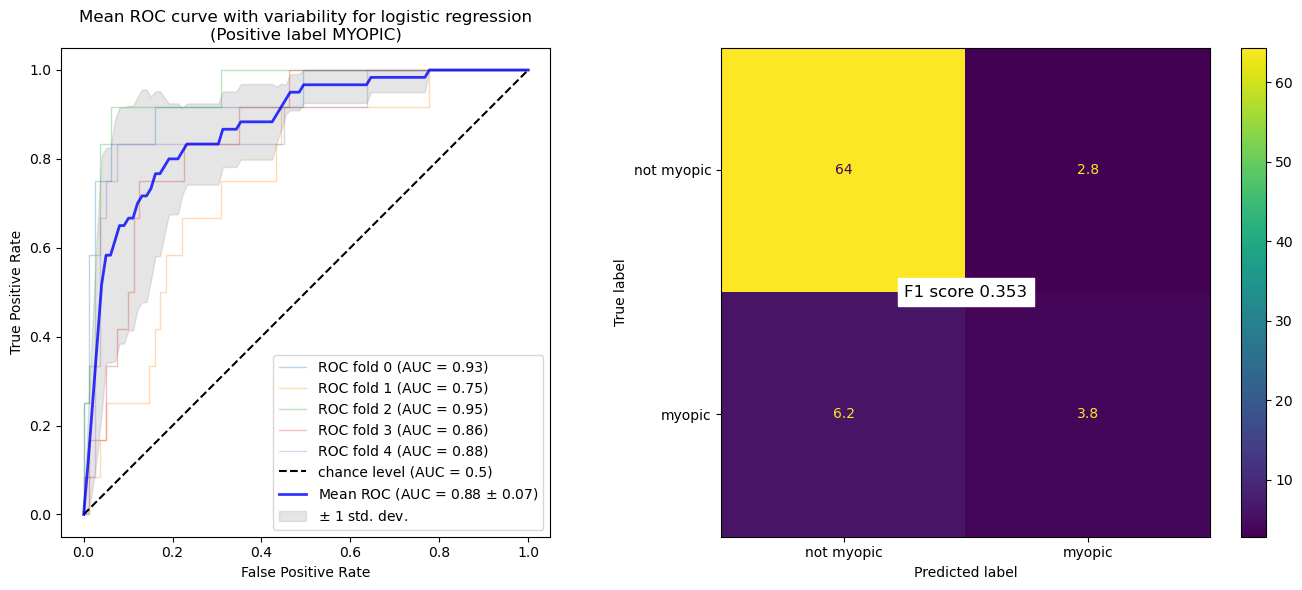

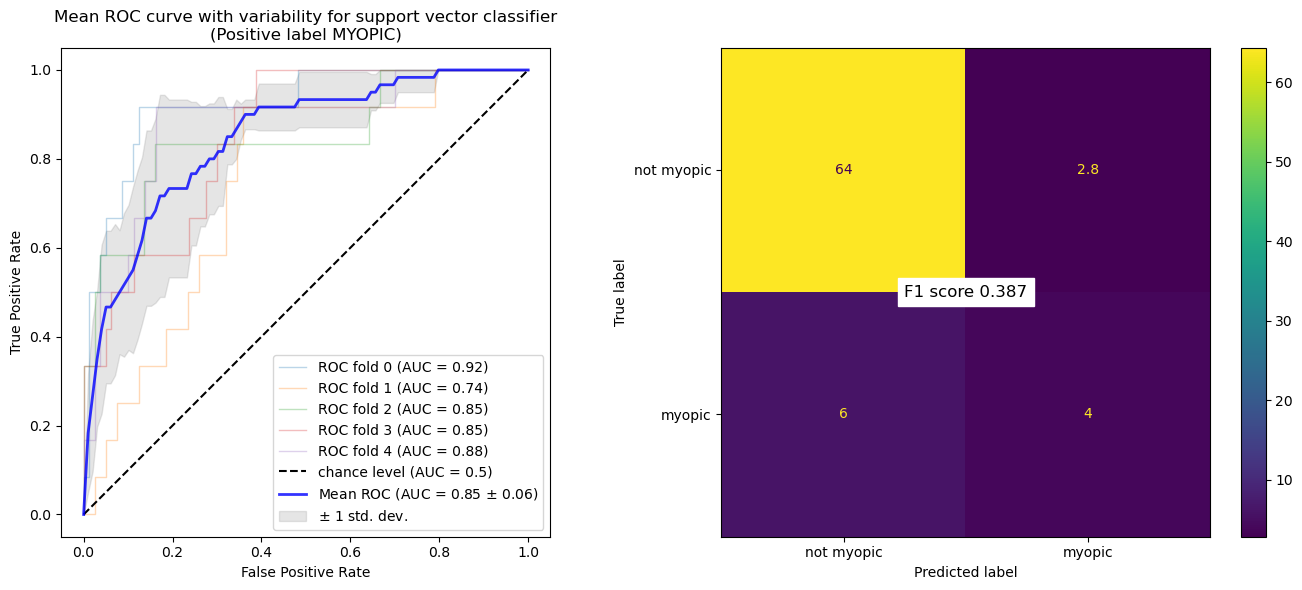

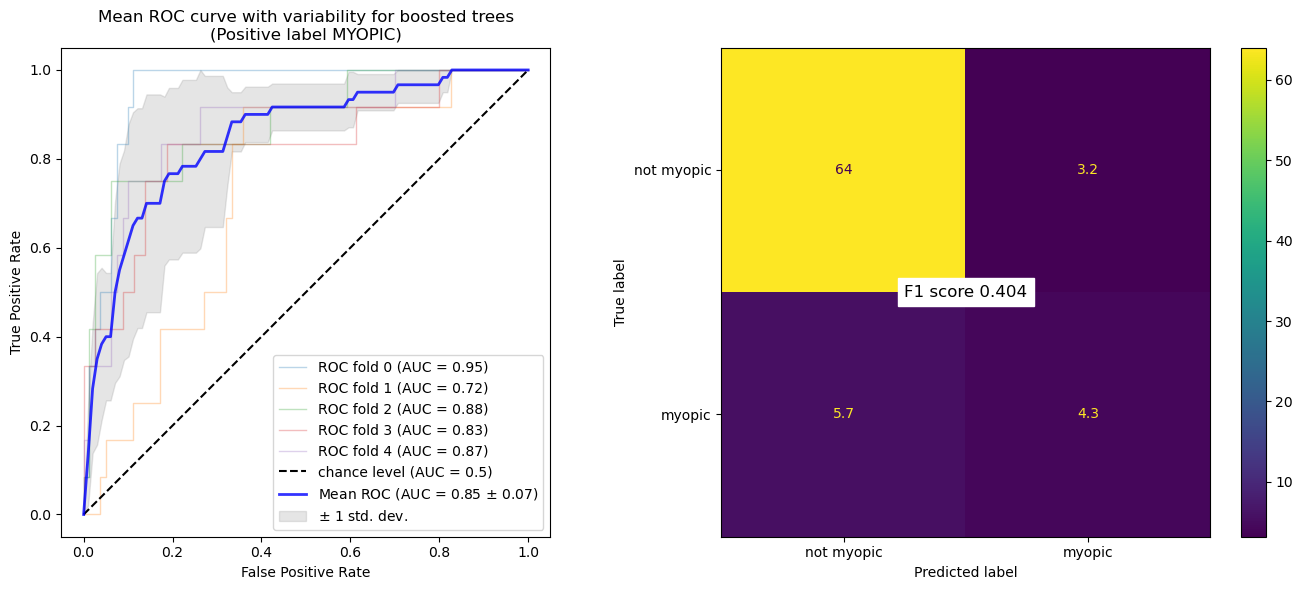

3/3 [==============================] - 0s 1ms/step


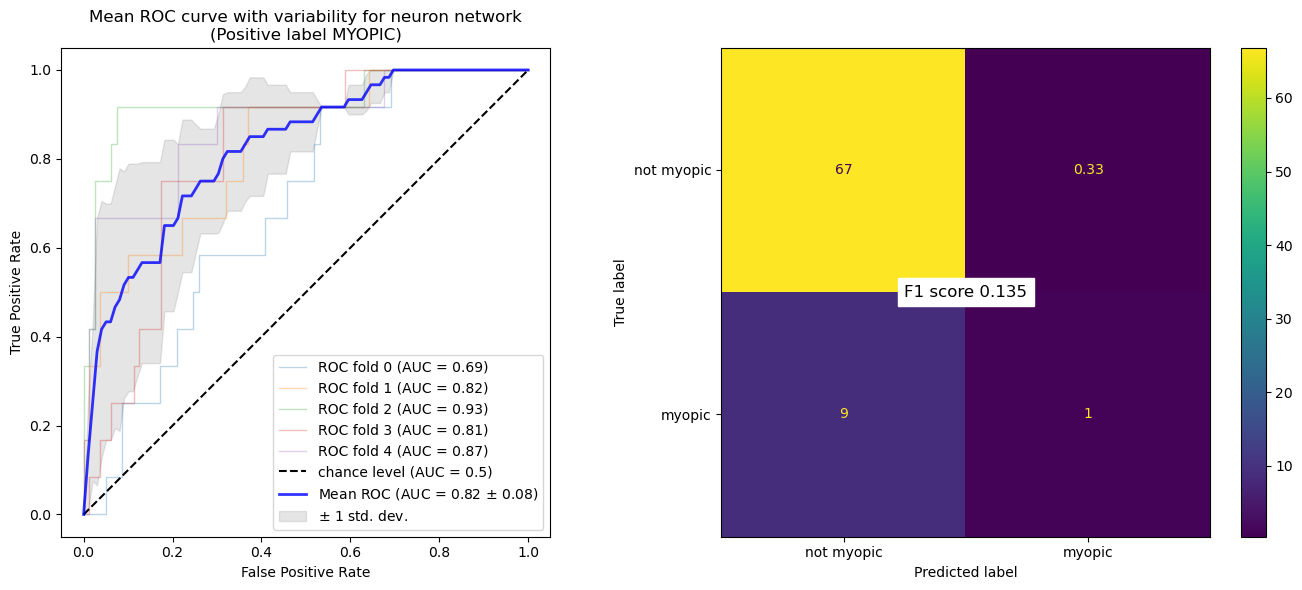

In [152]:
classifiers = [lr, svc, bst, model]
names = ['logistic regression', 'support vector classifier', 'boosted trees', 'neuron network']

train_and_view(classifiers, names, X_train, y_train)

In [153]:
from collections import Counter
from imblearn.over_sampling import SMOTE

sm = SMOTE()

X_res, y_res = sm.fit_resample(X_train, y_train)
print(f'Resampled dataset shape {Counter(y_res)}' % Counter(y_res))

Resampled dataset shape Counter({0: 403, 1: 403})


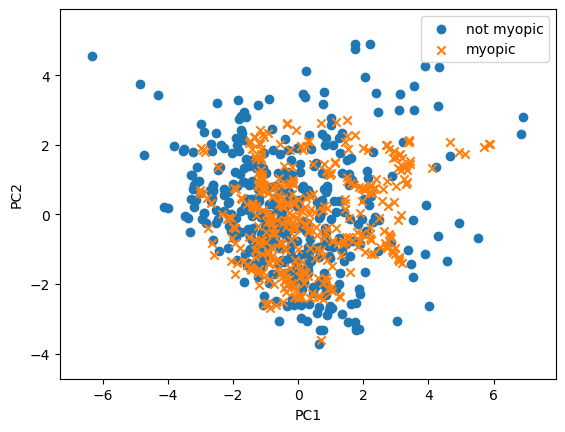

In [167]:
sc = StandardScaler()
pca = PCA(n_components=2)

X_train_std = sc.fit_transform(X_res)
X_train_pca = pca.fit_transform(X_train_std)

x1_min, x1_max = X_train_pca[:,0].min()-1, X_train_pca[:,0].max()+1
x2_min, x2_max = X_train_pca[:,1].min()-1, X_train_pca[:,1].max()+1

plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)

plt.scatter(x=X_train_pca[y_res == 0, 0],
            y=X_train_pca[y_res == 0, 1],
            marker='o',
            label='not myopic')

plt.scatter(x=X_train_pca[y_res == 1, 0],
            y=X_train_pca[y_res == 1, 1],
            marker='x',
            label='myopic')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

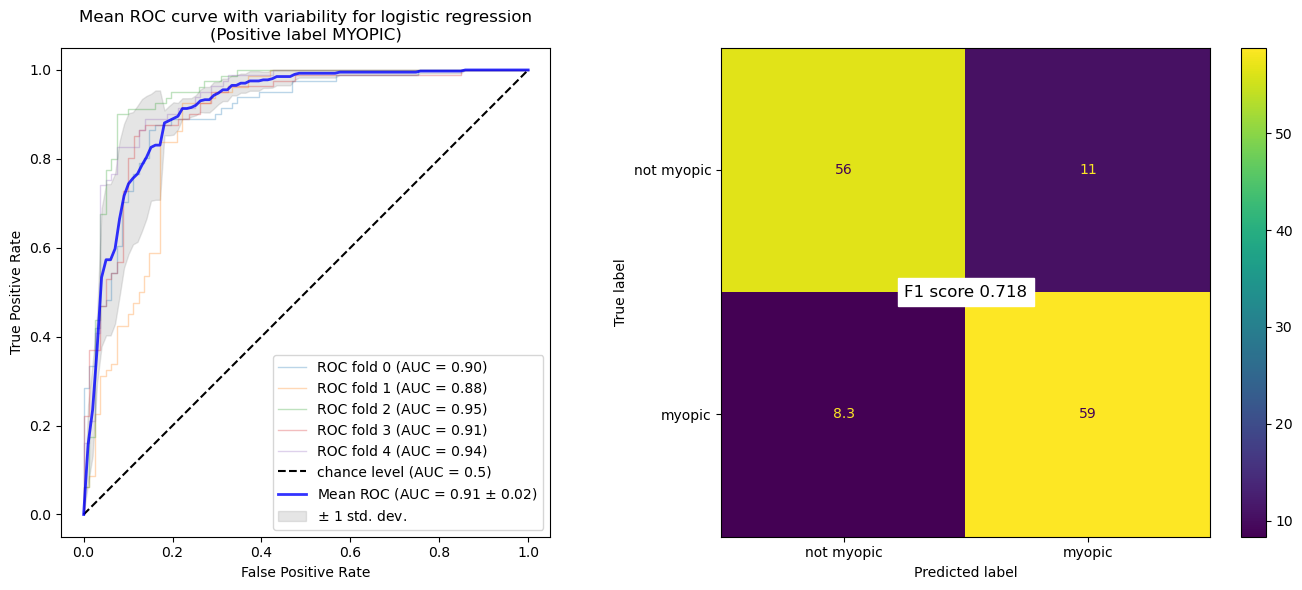

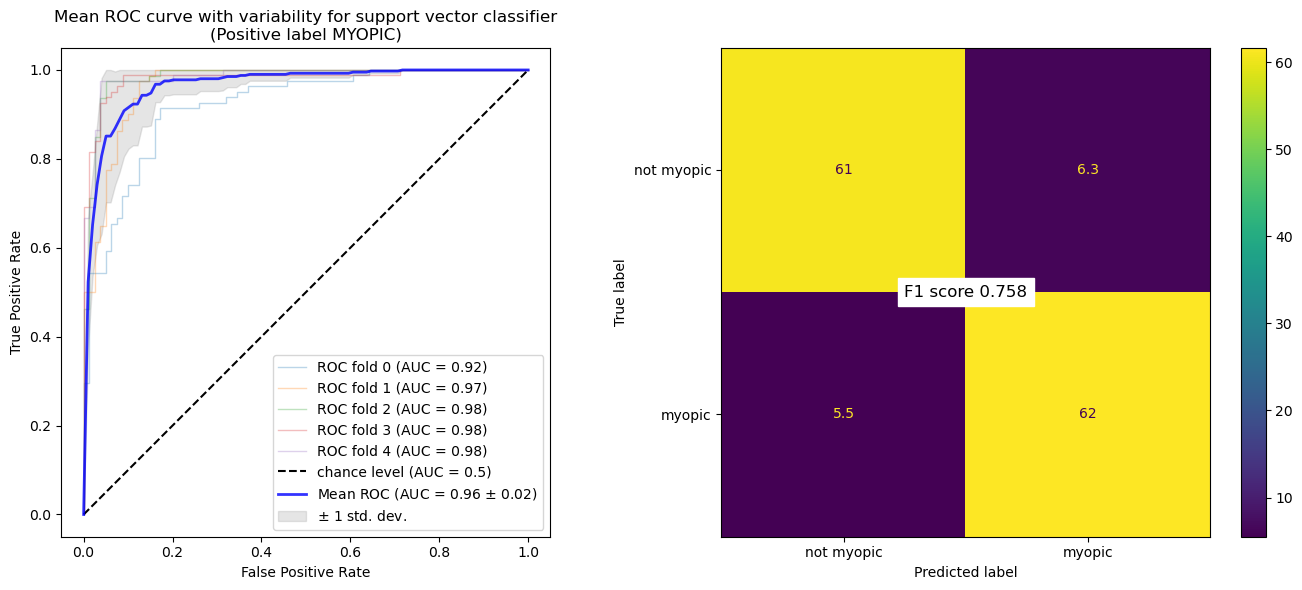

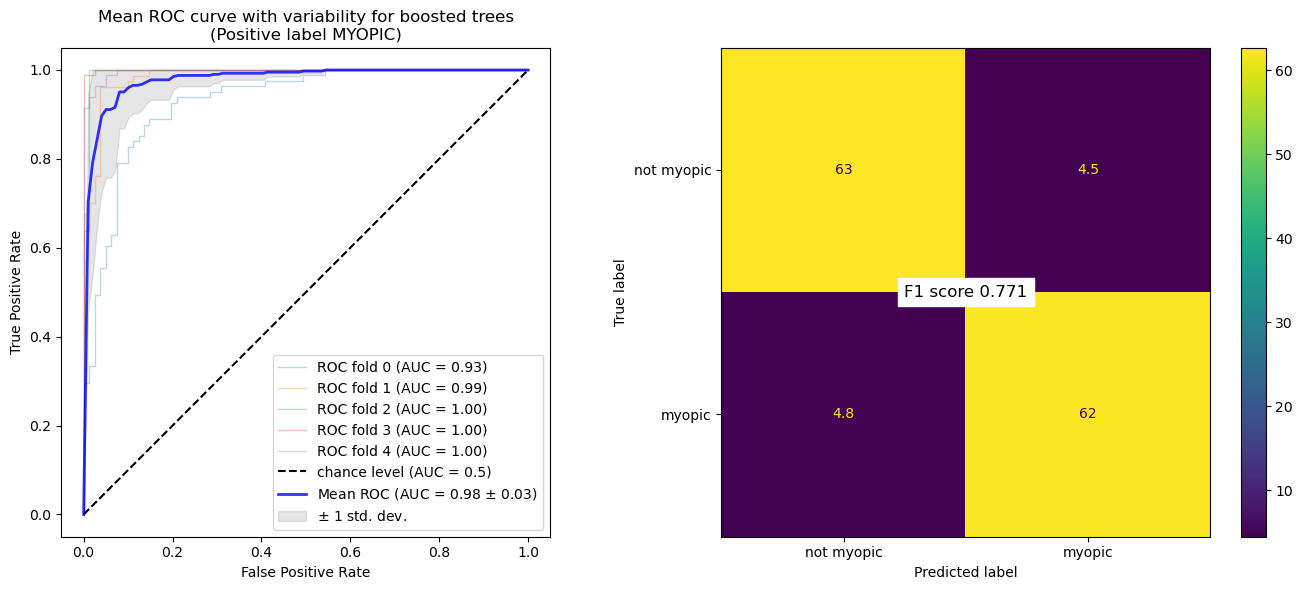

6/6 [==============================] - 0s 1ms/step


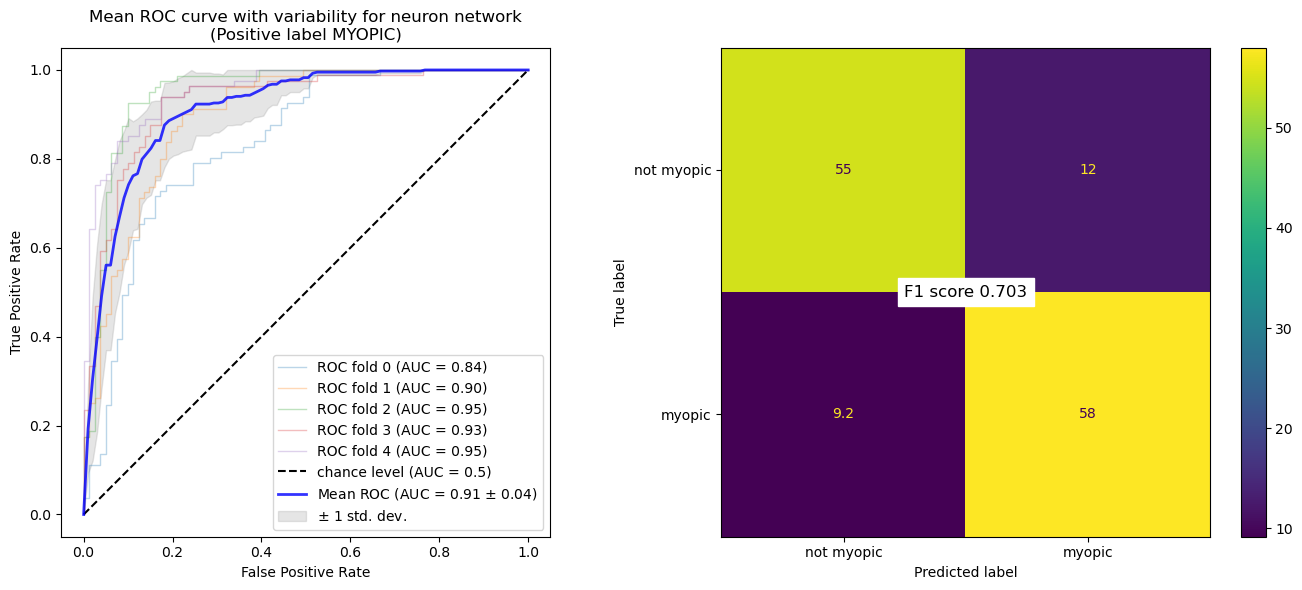

In [159]:
lr = LogisticRegression(C=100, solver='lbfgs')
forest = RandomForestClassifier(n_estimators=500)
bst = XGBClassifier(n_estimators=1000, objective='binary:logistic')
svc = SVC(C=params['svc__C'], kernel=params['svc__kernel'], gamma=params['svc__gamma'])
model = build_model(best_hps)

classifiers = [lr, svc, bst, model]
names = ['logistic regression', 'support vector classifier', 'boosted trees', 'neuron network']

train_and_view(classifiers, names, X_res, y_res)

From the results above, it looks like the gradient boosted tree has the highest F1 score. We now test this model on the test dataset, and assess its performance.

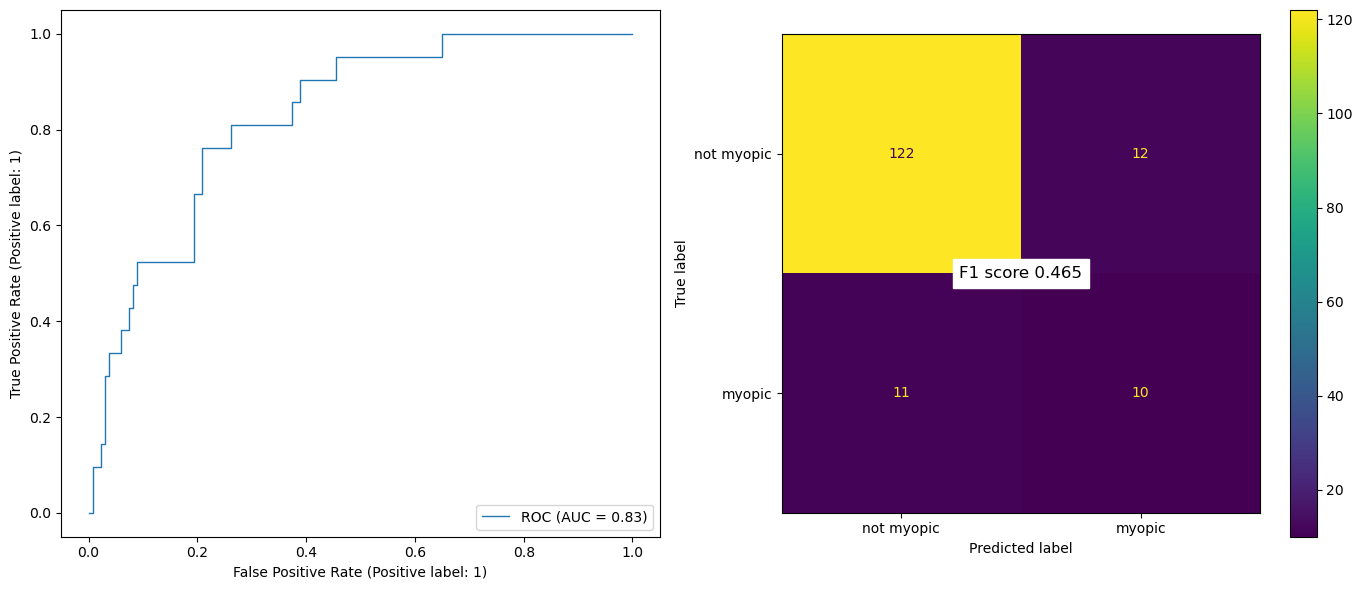

In [164]:
bst = XGBClassifier(n_estimators=1000, objective='binary:logistic')

bst.fit(X_train, y_train)

y_pred = bst.predict(X_test)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
RocCurveDisplay.from_estimator(
    bst,
    X_test,
    y_test,
    name="ROC",
    alpha=1,
    lw=1,
    ax=axs[0],
)

cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(['not myopic', 'myopic']))
disp.plot(ax=axs[1])

axs[1].text(0.5,0.5, 'F1 score {:.3f}'.format(f1),
            horizontalalignment='center', verticalalignment='center',
            backgroundcolor='white', fontsize='large')

plt.tight_layout()
plt.show()

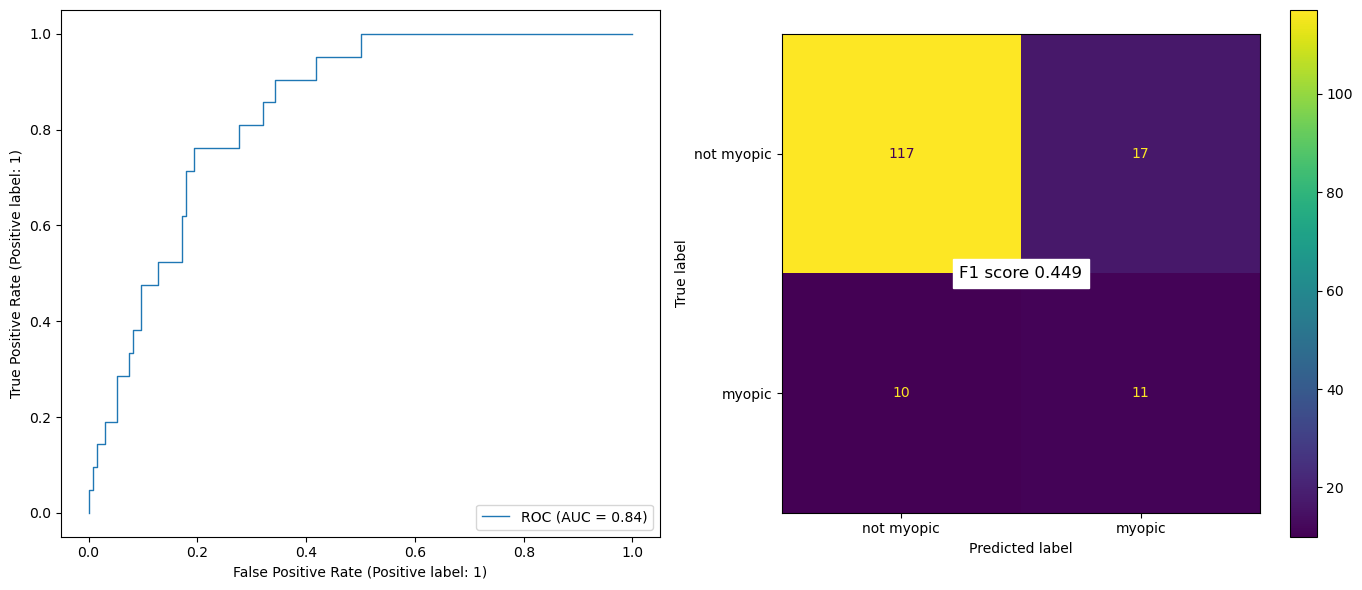

In [165]:
bst = XGBClassifier(n_estimators=1000, objective='binary:logistic')

bst.fit(X_res, y_res)

y_pred = bst.predict(X_test)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
RocCurveDisplay.from_estimator(
    bst,
    X_test,
    y_test,
    name="ROC",
    alpha=1,
    lw=1,
    ax=axs[0],
)

cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(['not myopic', 'myopic']))
disp.plot(ax=axs[1])

axs[1].text(0.5,0.5, 'F1 score {:.3f}'.format(f1),
            horizontalalignment='center', verticalalignment='center',
            backgroundcolor='white', fontsize='large')

plt.tight_layout()
plt.show()